##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# On-Device Training in TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/on_device_training/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

To use TensorFlow Lite, typically you need to prepare a TensorFlow model, use the converter to convert it to TensorFlow Lite model format, and run the model using TensorFlow Lite on device. You can follow the same flow for training and [inference models](https://www.tensorflow.org/lite/guide/inference).

The following code illustrates the high-level flow of preparing a TensorFlow training model, converting it to TensorFlow Lite model and running in TensorFlow Lite to classify clothing types using the [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

The implementation is based on the [Keras classification example](https://www.tensorflow.org/tutorials/keras/classification) in the TensorFlow official guide page.

With this Colab, you can explore new ways of training off-the-shelf Machine learning models with TensorFlow Lite.

## Setup
To get the Colab running, you'll need to download and install the following packages.

**Note:** This API is new and only available via `pip install tf-nightly`. It will be available in TensorFlow version 2.7.

In [ ]:
!pip uninstall -y tensorflow keras
!pip install tf-nightly

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Classify images of clothing

This Colab trains a neural network model on the [Fashion MNIST dataset](https://keras.io/api/datasets/fashion_mnist/) to classify images of clothing, like sneakers and shirts.

We'll use 60,000 images to train the network, and 10,000 images to test the accuracy of the model: how well did the model learn to classify those images correctly? You can access the Fashion MNIST directly from TensorFlow. Import and load the [Fashion MNIST dataset](https://keras.io/api/datasets/fashion_mnist/) directly from TensorFlow and it will return four Numpy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

In [39]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

In [40]:
train_images.shape

(60000, 28, 28)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [41]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let’s familiarize ourselves with what the images in our training set look like by plotting the training images and labels.

Define a function `plot()` to print 25 images and their labels.

In [42]:
def plot(images, labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(class_names[labels[i]])
  plt.show()

Plot training images

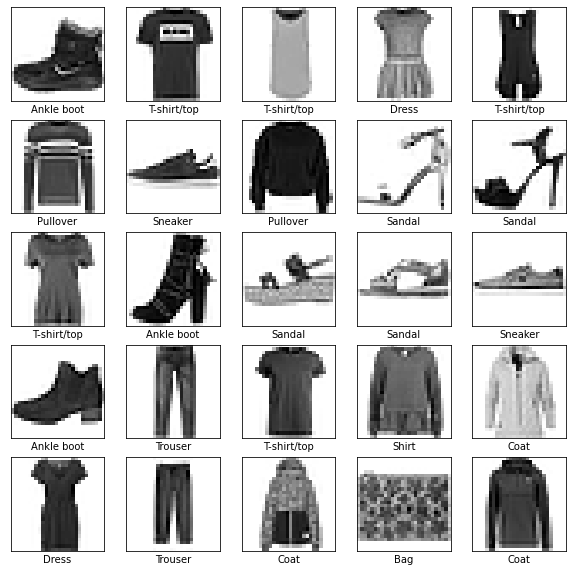

In [43]:
plot(train_images, train_labels)

### TensorFlow Model for Training

Instead of converting a single TensorFlow model or tf.function to a TensorFlow Lite model with a single entry point, we can convert multiple tf.function(s) into a TensorFlow Lite model. To be able to do that, we're extending the TensorFlow Lite's converter & runtime to handle multiple signatures.

Preparing a TensorFlow Model. The code constructs a tf.module with 4 tf.functions:
*   train function trains the model with training data.
*   infer function invokes the inference.
*   save function saves the trainable weights into the file system.
*   restore function loads the trainable weights from the file system.

The weights will be serialized as a TensorFlow version one checkpoint file format.

In [44]:
IMG_SIZE = 28


class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    self._LOSS_FN = tf.keras.losses.CategoricalCrossentropy()
    self._OPTIM = tf.optimizers.SGD()

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    # Gradient tape is used for recording operations for automatic
    # differentiation. You can refer to
    # https://www.tensorflow.org/api_docs/python/tf/GradientTape for more
    # details on how to use it.
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self._LOSS_FN(prediction, y)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self._OPTIM.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    for grad in gradients:
      result[grad.name] = grad
    return result

  @tf.function(input_signature=[tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32)])
  def predict(self, x):
    return {
        "output": self.model(x)
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

### Convert to TensorFlow Lite model

We now have the TensorFlow model, but to make sure it runs on TensorFlow Lite, we have to convert it. This code converts our model to the right format, and, in addition, our output will be a set of 4 signatures that we'll use to run the TensorFlow Lite model below: `train, infer, save, restore`.

In [45]:
# Export the TensorFlow model to the saved model
SAVED_MODEL_DIR = "saved_model"
m= Model()
tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.predict.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

### Train the TensorFlow Lite model


#### Preprocess the dataset

* Scale images from 0-255 to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255.
* Convert labels to categorical values, i.e, perform one-hot encoding.

It's important that the *training set* and the *testing set* be preprocessed in the same way.

In [46]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

#### Setup the TensorFlow Lite

TensorFlow Lite's converter and interpreter support multi-signature. Developers can choose to invoke restoring, training, saving and inferring signatures separately.

In [47]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

train = interpreter.get_signature_runner("train")
infer = interpreter.get_signature_runner("infer")
save = interpreter.get_signature_runner("save")
restore = interpreter.get_signature_runner("restore")

On Android, TensorFlow Lite on-device training can be performed using either Java or C++ APIs. In this document, we describe how the above TensorFlow Lite model will work with Java API.

#### Train the model

Using the preprocessed dataset and the `train` signature method.

Finished 10 epochs, current loss: 4.234197616577148
Finished 20 epochs, current loss: 4.153818130493164
Finished 30 epochs, current loss: 4.09471321105957
Finished 40 epochs, current loss: 4.049306869506836
Finished 50 epochs, current loss: 4.074450492858887
Finished 60 epochs, current loss: 4.049517631530762
Finished 70 epochs, current loss: 4.011128902435303
Finished 80 epochs, current loss: 3.8494346141815186
Finished 90 epochs, current loss: 3.86380672454834
Finished 100 epochs, current loss: 3.7599244117736816


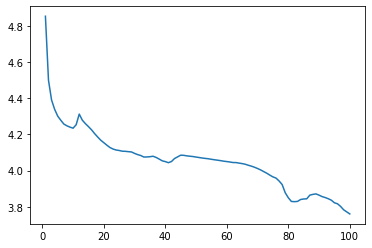

In [48]:
# Run training for a few steps, this may take a few minutes to finish. The loss
# value will be printed every 10 epochs.
# Within each epoch, we will split the training data into batches of size 100.
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])

for i in range(NUM_EPOCHS):
  for batch_idx in range(len(train_images) // BATCH_SIZE):
    batched_images = train_images[BATCH_SIZE*(batch_idx) : BATCH_SIZE * (batch_idx + 1)]
    batched_labels = train_labels[BATCH_SIZE*(batch_idx) : BATCH_SIZE * (batch_idx + 1)]
    result = train(
        x=tf.constant(batched_images, shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE),
                      dtype=tf.float32),
        y=tf.constant(batched_labels, shape=(BATCH_SIZE, 10), dtype=tf.float32))
  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print('Finished {0} epochs, current loss: {1}'.format(i + 1, losses[i]))

plt.plot(epochs, losses)
plt.show()

In Java, you'll use the `Interpreter` class to load a model and drive model training tasks.
The following example shows how to run the training procedure by using the `runSignature` method:

```
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int NUM_TRAININGS = 60000;
    float[][][] trainImages = new float[NUM_TRAININGS][28][28];
    float[][] trainLabels = new float[NUM_TRAININGS][10];

    // Fill the data values.

    // Run training for a few steps.
    for (int i = 0; i < NUM_EPOCHS; ++i) {
        Map<String, Object> inputs = new HashMap<>();
        inputs.put("x", trainImages);
        inputs.put("y", trainLabels);
        Map<String, Object> outputs = new HashMap<>();
        FloatBuffer loss = FloatBuffer.allocate(1);
        outputs.put("loss", loss);
        interpreter.runSignature(inputs, outputs, "train");
    }

    // Do the other stuffs..
}
```

### Run inference on the trained TensorFlow Lite model
Now we have a trained TensorFlow Lite model, we can run inference on the test images using the signature runner API:

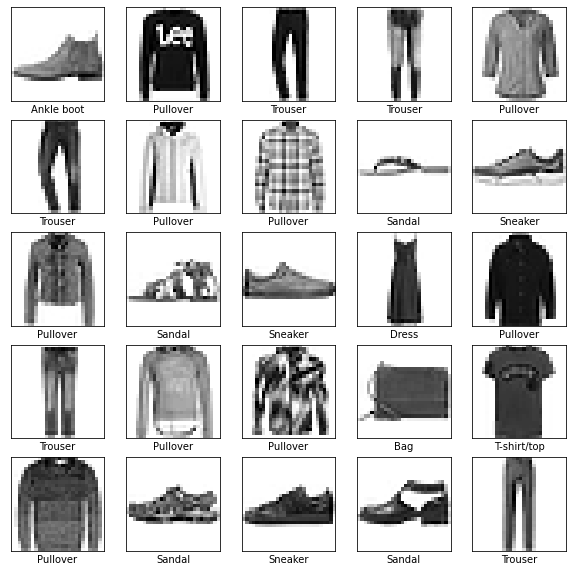

In [49]:
infer = interpreter.get_signature_runner("infer")
result = infer(
    x=tf.constant(test_images, shape=(len(test_images), IMG_SIZE, IMG_SIZE), dtype=tf.float32))
result_labels = np.argmax(result["output"], axis=1)
plot(test_images, result_labels)

### Export the trained weights to the checkpoint file

The checkpoint file can be generated through the `save` signature method.

In [ ]:
save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

In Java, you can store the trained weight as a checkpoint format into the internal storage of the application. Training tasks usually perform at the idle time (e.g., at night time) in the background process occasionally.

```
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    interpreter.runSignature(inputs, outputs, "save");
}
```

### Restore the trained weights from the checkpoint file

The exported checkpoint file can be restored through the `restore` signature method.

In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)

train = another_interpreter.get_signature_runner("train")
infer = another_interpreter.get_signature_runner("infer")
save = another_interpreter.get_signature_runner("save")
restore = another_interpreter.get_signature_runner("restore")

# Restore the trained weights from /tmp/model.ckpt
# The time spent in weight restoration is proportionate to the checkpoint size
# and the number of variables in the model.
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'dense/bias:0': array([ 0.04012525,  0.2057373 ,  0.2243858 , -0.24513818, -0.02761128,
         0.09906419, -0.11930446,  0.04712639, -0.16470878,  0.01239975,
        -0.00356665, -0.22564562, -0.10880154, -0.01482808,  0.06578001,
        -0.04510193, -0.03627148,  0.2789909 ,  0.13839999,  0.00209918,
         0.17772792, -0.04050817,  0.00417841,  0.05942791,  0.12545821,
        -0.00292166, -0.00278226,  0.05466946,  0.22082086, -0.00598721,
        -0.01459187,  0.02165319,  0.18708995, -0.02477028, -0.08105396,
        -0.04406855,  0.06384442,  0.05739888,  0.08162292, -0.02138082,
        -0.0134026 ,  0.00778261,  0.14147109, -0.00077838,  0.28427938,
        -0.15945041,  0.06246428, -0.01937703,  0.1309807 ,  0.1728773 ,
         0.10792284,  0.06019975, -0.19701743,  0.0174903 ,  0.1654197 ,
        -0.0681069 , -0.00954542,  0.0846714 , -0.07780166,  0.09400689,
         0.05912594, -0.2068568 , -0.19693165, -0.00241943,  0.05349341,
         0.15399657,  0.07771349, -

In Java, you can restore the serialized trained weights from the file, stored at the internal storage. When the application restarts, the trained weights
usually need to be restored prior to the inferences.

```
try (Interpreter another_interpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    another_interpreter.runSignature(inputs, outputs, "restore");
}
```

### Run Inference using the trained weights

Developers can use the trained model to run inference through the `infer` signature method.

In [ ]:
result = infer(
    x=tf.constant(test_images, shape=(len(test_images), IMG_SIZE, IMG_SIZE), dtype=tf.float32))
result_labels = np.argmax(result["output"], axis=1)

Plot the predicted labels

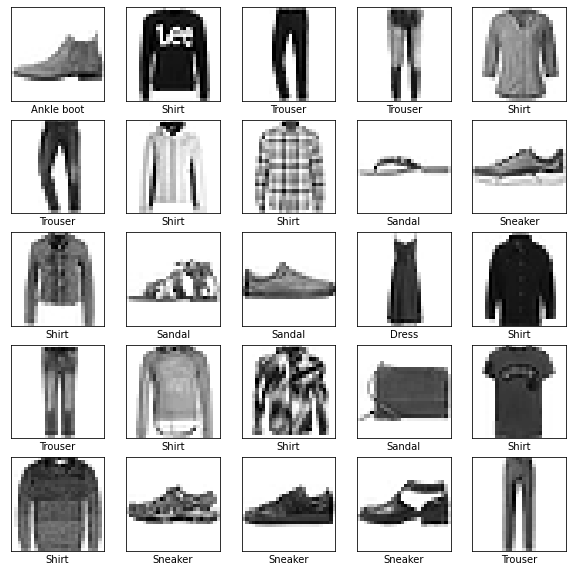

In [ ]:
plot(test_images, result_labels)

In Java, after restoring the trained weights, developers can run the inferences based on the loaded data.

```
try (Interpreter another_interpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    float[][][] testImages = new float[NUM_TESTS][28][28];
    float[][] output = new float[NUM_TESTS][10];

    // Fill the test data.

    // Run the inference.
    inputs = new HashMap<>();
    inputs.put("x", testImages);
    outputs = new HashMap<>();
    outputs.put("output", output);
    another_interpreter.runSignature(inputs, outputs, "infer");

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output[i][index] < output[i][j]) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```

And, that’s it! You now have a TensorFlow Lite model that is able to do on-device training. We hope that this code walkthrough gives you a good idea on how to run on-device training in TensorFlow Lite, and we’re excited to see where you take it.
